In [1]:
# importi posebej, ker kdaj pozabi kaj je bilo importano?
import pandas as pd
import numpy as np
import isodate
import json
import datetime
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.options.display.max_rows = 10

# izberemo interaktivni "notebook" stil risanja
%matplotlib inline
# naložimo razpredelnico, s katero bomo delali
ar_ingredients = pd.read_csv('data/ar_ingredients.csv')
ar_recipes = pd.read_csv('data/ar_recipes.csv', index_col='id')
ar_steps = pd.read_csv('data/ar_steps.csv')
jo_ingredients = pd.read_csv('data/jo_ingredients.csv')
jo_recipes = pd.read_csv('data/jo_recipes.csv', index_col='id')
jo_steps = pd.read_csv('data/jo_steps.csv')
jo_tags = pd.read_csv('data/jo_tags.csv')
ingredient_list = pd.read_csv('data/ingredient_list.csv')

# Ogrevanje

Poglejmo si povprečno število korakov in sestavin za obe strani.

Narisal bom tudi stolpični diagram skaliran glede na skupno število receptov na posamezni strani.


In [3]:
def draw_scaled2(ax, mean1, mean2, table1, table2, f1, f2, c1='r', c2='b'):
    ax.axvline(x=mean1, color=c1)
    ax.axvline(x=mean2, color=c2)
    ax.legend(['Jamie Oliver', 'allrecipes'])
    for ing, s in table1.iterrows():
        ax.bar(ing, (s / f1), color=c1, width=0.4, align='edge')
    for ing, s in table2.iterrows():
        ax.bar(ing, (s / f2), color=c2, width=-0.4, align='edge')

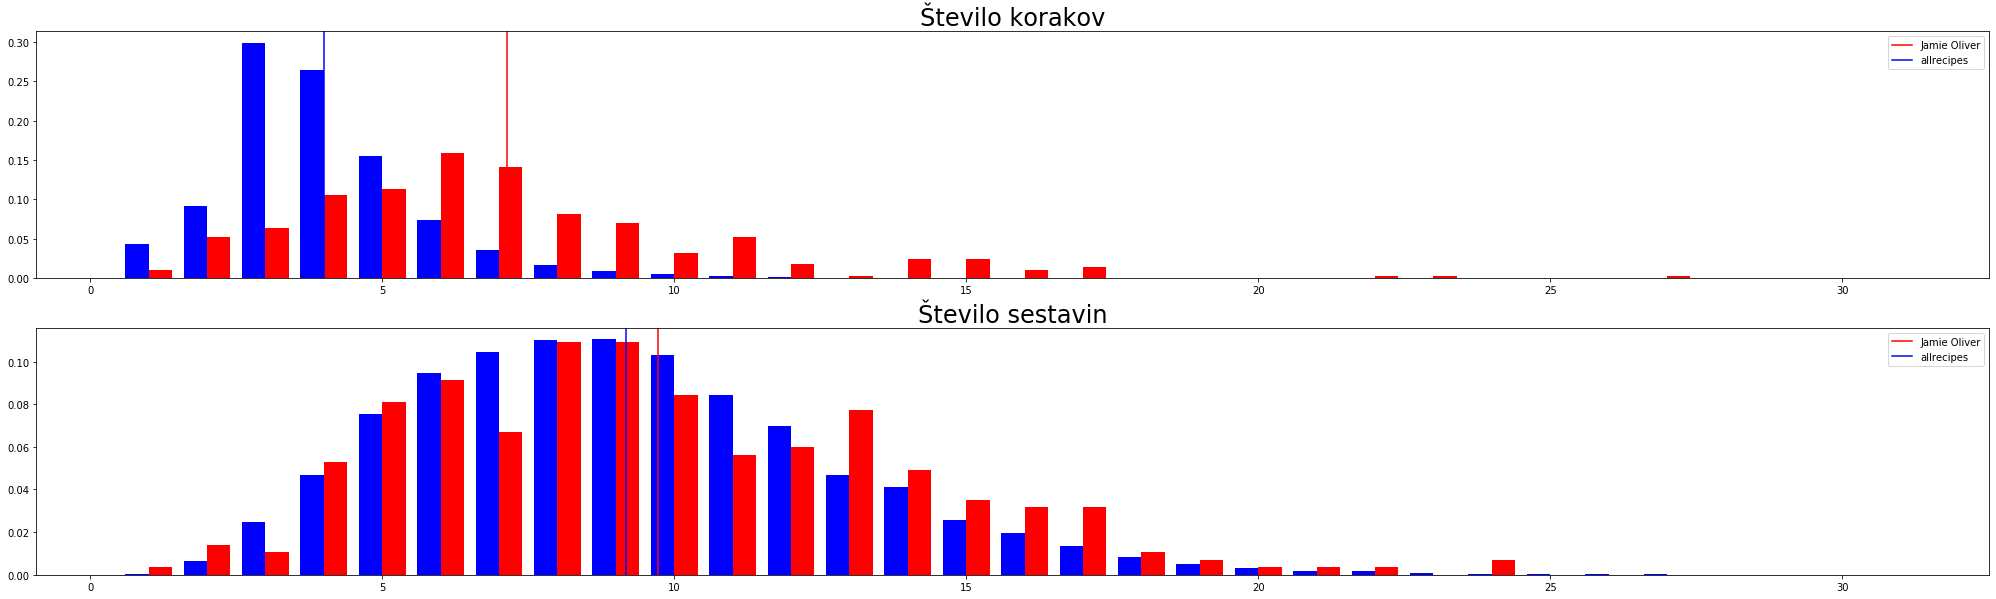

In [4]:
# calculate average number of steps
jo_steps_by_recipe = jo_steps.groupby('recipe').count()
ar_steps_by_recipe = ar_steps.groupby('recipe').count()
mean_jo_steps = jo_steps_by_recipe.seq.mean()
mean_ar_steps = ar_steps_by_recipe.seq.mean()
# print(f'Povprečno število korakov na jamieoliver.com: {mean_jo_steps:.0f}')
# print(f'Povprečno število korakov na allrecipes.com: {mean_ar_steps:.0f}')

jo_ingredients_by_recipe = jo_ingredients.groupby('recipe').count()
ar_ingredients_by_recipe = ar_ingredients.groupby('recipe').count()
mean_jo_ingredients = jo_ingredients_by_recipe.ingredient.mean()
mean_ar_ingredients = ar_ingredients_by_recipe.ingredient.mean()
# print(f'Povprečno število sestavin na jamieoliver.com: {mean_jo_ingredients:.0f}')
# print(f'Povprečno število sestavin na allrecipes.com: {mean_ar_ingredients:.0f}')

jo_recipes_per_number_of_steps = jo_steps_by_recipe.groupby('seq').count()
ar_recipes_per_number_of_steps = ar_steps_by_recipe.groupby('seq').count()

jo_recipes_per_number_of_ingredients = jo_ingredients_by_recipe.groupby('ingredient').count()
ar_recipes_per_number_of_ingredients = ar_ingredients_by_recipe.groupby('ingredient').count()

fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(211)
ax1.set_title("Število korakov", size=24)
draw_scaled2(ax1, mean_jo_steps, mean_ar_steps, jo_recipes_per_number_of_steps, ar_recipes_per_number_of_steps, len(jo_recipes), len(ar_recipes))

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.set_title('Število sestavin', size=24)
draw_scaled2(ax2, mean_jo_ingredients, mean_ar_ingredients, jo_recipes_per_number_of_ingredients, ar_recipes_per_number_of_ingredients, len(jo_recipes), len(ar_recipes))

Graf 1: Histogram glede na število korakov z označenim povprečnim številom korakov.

Graf 2: Histogram glede na število sestavin z označenim povprečnim številom sestavin.


Tu lahko opazimo, da ima Jamie Oliver bolj zapletene recepte kot plebejci na allrecipes.com, ali pa Jamie Oliver razbije recept na manjše korake.

Jamie Oliver pogosteje uporabi tudi več sestavin. 

# Prva hipoteza

Večina sladic vsebuje čokolado.

In [5]:
jo_contains_chocolate = jo_ingredients.where(jo_ingredients.ingredient.str.contains(r'chocolate'))
ar_contains_chocolate = ar_ingredients.where(ar_ingredients.ingredient.str.contains(r'chocolate'))
no_jo_chocolate = len(jo_contains_chocolate.groupby('recipe').count())
no_ar_chocolate = len(ar_contains_chocolate.groupby('recipe').count())
print(f'Število receptov s čokolado na jamieoliver.com: {no_jo_chocolate} / {jo_recipes.name.count()} = {100 * no_jo_chocolate / jo_recipes.name.count():.0f} %')
print(f'Število receptov s čokolado na allrecipes.com: {no_ar_chocolate} / {ar_recipes.name.count()} = {100 * no_ar_chocolate / ar_recipes.name.count():.0f} %')

Število receptov s čokolado na jamieoliver.com: 82 / 284 = 29 %
Število receptov s čokolado na allrecipes.com: 3362 / 13277 = 25 %


Prvo hipotezo lahko ovržemo, ker manj kot 50 % receptov zahteva čokolado. :(

# Druga hipoteza

Sladice imajo veliko sladkorja/kalorij.

Ker imam podatke o kalorijah le za allrecipes.com, bom opravil analizo le na teh.

In [6]:
mean_cals = ar_recipes.cals.mean()
print(f'Povprečno imajo sladice {mean_cals:.0f} kalorij.')

Povprečno imajo sladice 302 kalorij.


En sošolec mi je rekel, da 300 kalorij ni niti veliko niti malo, tako da zgleda ovržemo hipotezo ¯\\\_(ツ)_/¯

Če bi imel časovni stroj, bi si poslal sporočilo v preteklost naj dam kaj drugega namesto tega.

# Tretja hipoteza.

Čas priprave je neodvisen od prisotnosti določenih sestavin.

In [7]:
def to_minutes(ts: str) -> int:
    """Pretvori tabelo trajanj v ISO8601 formatu v število minut.
    
    Funkcija vzame zgolj zadnji podatek iz tabele, ker ta predstavlja skupno trajanje priprave.
    """
    if ts == '[]':
        return -1
    ts = ts.replace("\'", '\"')
    ready_in = json.loads(ts)[-1]  # last field is ready_in
    tot = isodate.parse_duration(ready_in)
    return int(tot.total_seconds() // 60)

def draw_with_mean(ax, table, mean, f=(lambda x: x)):
    """Nariše stolpični diagram in vriše povprečje. Podatke iz vrstice izluščimo z f."""
    fig.autofmt_xdate()  # ni datum, ampak dela
    ax.axhline(y=mean)
    for ing, s in table.iterrows():
        ax.bar(ing, f(s))


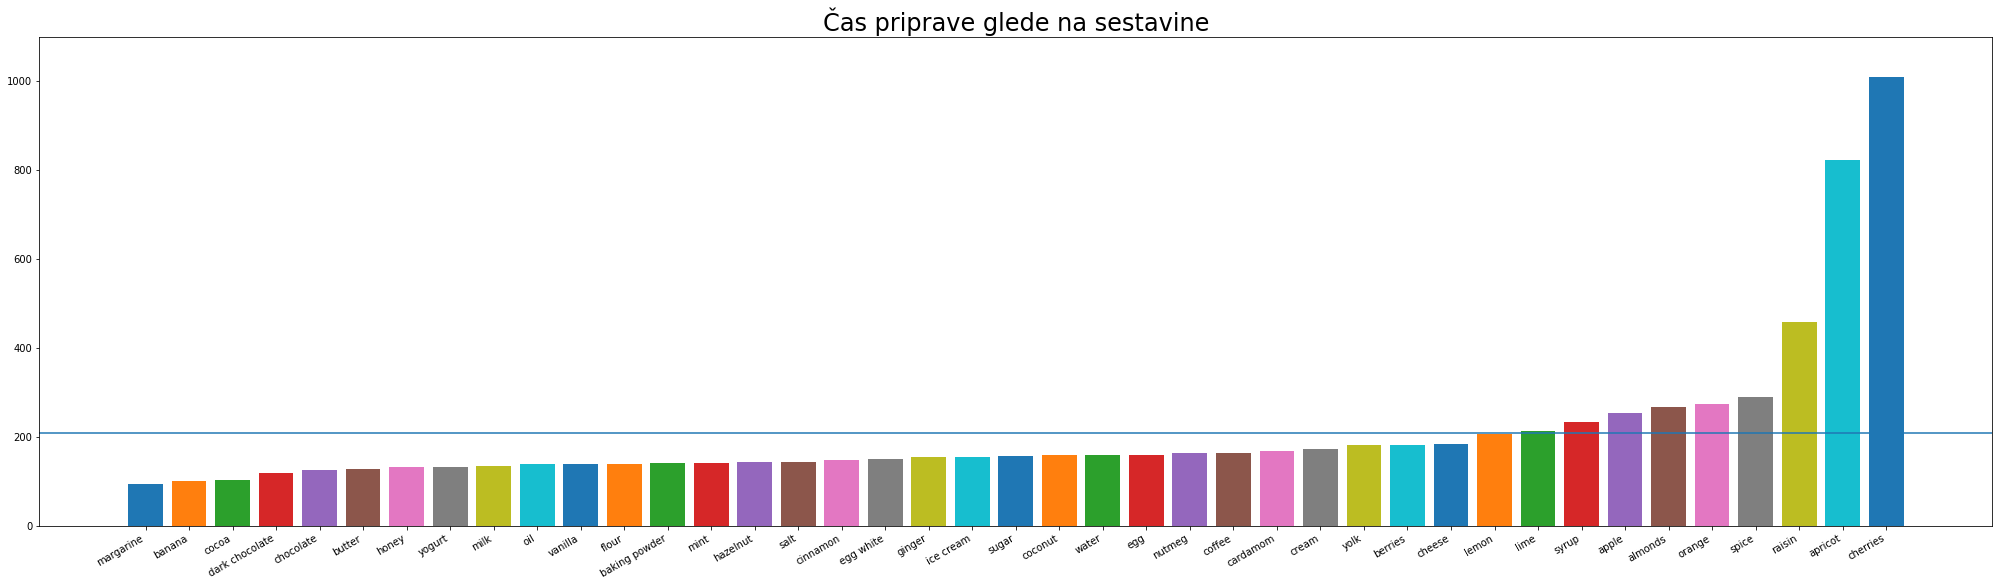

In [8]:
times = dict()
for ing in ingredient_list.ingredient:
    jo_contains_ing = jo_ingredients[jo_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    ar_contains_ing = ar_ingredients[ar_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    # print(f'{ing}: {len(jo_contains_ing.count())}')
    ar_recipes_with_ing = ar_recipes.filter(items=list(ar_contains_ing.count().index), axis=0)
    ar_time_converted = ar_recipes_with_ing.time.apply(to_minutes)
    ar_mean_time = ar_time_converted[ar_time_converted > 0].mean()
    ar_recipe_count = len(ar_contains_ing)
    times[ing] = [int(ar_mean_time), ar_recipe_count]  # round to whole minute
    
ar_time_by_ingredient = pd.DataFrame.from_dict(times, orient='index', columns=['time', 'count'])
ar_time_table = ar_time_by_ingredient[ar_time_by_ingredient['count'] >= 100].sort_values(by='time')  # odstranimo sestavine ki so malo zastopane
mean_time = ar_time_table.time.mean()

fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(111)
ax1.set_title("Čas priprave glede na sestavine", size=24)
ax1.set_ylim(0, 1100)
draw_with_mean(ax1, ar_time_table, mean_time, f=(lambda x: x.time))

Graf 3: Povprečen čas priprave za vsako sestavino.

Presenetljivo lahko vidimo, da je čas priprave sladic odvisen od določenih sestavin.

Ker se mi to zdi sumljivo, bom poskusil odstraniti oba ekstremna časa (najdaljšega in najkrajšega).

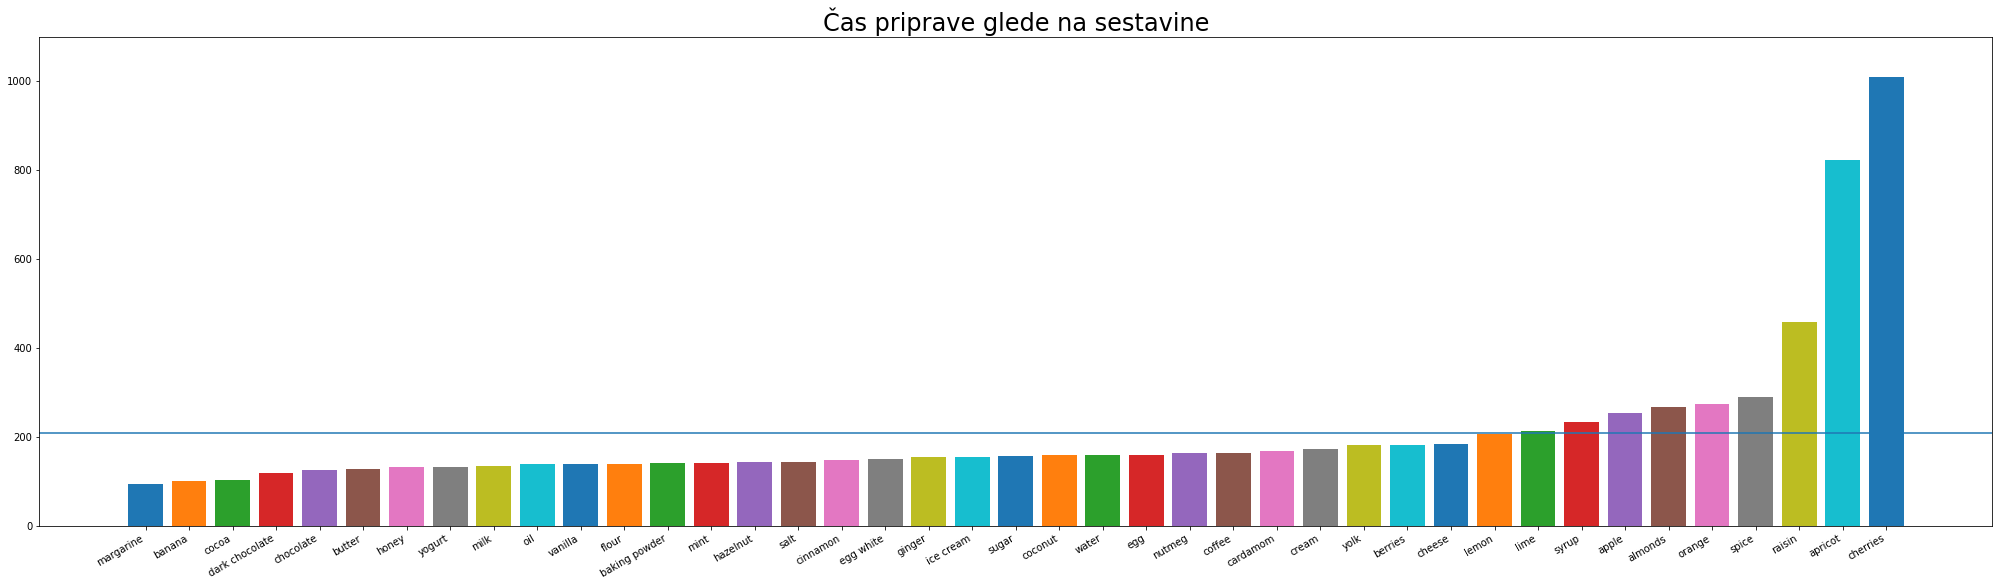

In [9]:
times = dict()
for ing in ingredient_list.ingredient:
    jo_contains_ing = jo_ingredients[jo_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    ar_contains_ing = ar_ingredients[ar_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    # print(f'{ing}: {len(jo_contains_ing.count())}')
    ar_recipes_with_ing = ar_recipes.filter(items=list(ar_contains_ing.count().index), axis=0)
    ar_time_converted = ar_recipes_with_ing.time.apply(to_minutes)
    ar_positive_times = ar_time_converted[ar_time_converted > 0]
    ar_removed_extreme_times = ar_positive_times.sort_values()[1:-1]  # odstranimo oba ekstrema
    ar_mean_time = ar_positive_times.mean()
    ar_recipe_count = len(ar_contains_ing) - 2
    times[ing] = [int(ar_mean_time), ar_recipe_count]  # round to whole minute

ar_time_by_ingredient = pd.DataFrame.from_dict(times, orient='index', columns=['time', 'count'])
ar_time_table = ar_time_by_ingredient[ar_time_by_ingredient['count'] >= 100].sort_values(by='time')  # odstranimo sestavine ki so malo zastopane
mean_time = ar_time_table.time.mean()

fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(111)
ax1.set_title("Čas priprave glede na sestavine", size=24)
ax1.set_ylim(0, 1100)
draw_with_mean(ax1, ar_time_table, mean_time, f=(lambda x: x.time))

Graf 4: Povprečen čas priprave za vsako sestavino.

Kot vidimo se graf ne spremeni veliko. Če bi znal kaj statistike, bi si lahko pomagal s standardnim odklonom, vendar bo to za potrebe te naloge zadoščalo.

# Dodatno

Poglejmo si še ocene receptov s čokolado v primerjavi z ostalimi sladicami.

In [10]:
from typing import Tuple
def to_rating(ts: str) -> Tuple[float, int]:
    """Pretvori json string v par oblike (ocena, število_glasov)."""
    if ts == '{}':
        return (0, 0)
    ts = ts.replace("\'", '\"')
    rating = json.loads(ts)
    return float(rating['value']), int(rating['count'])

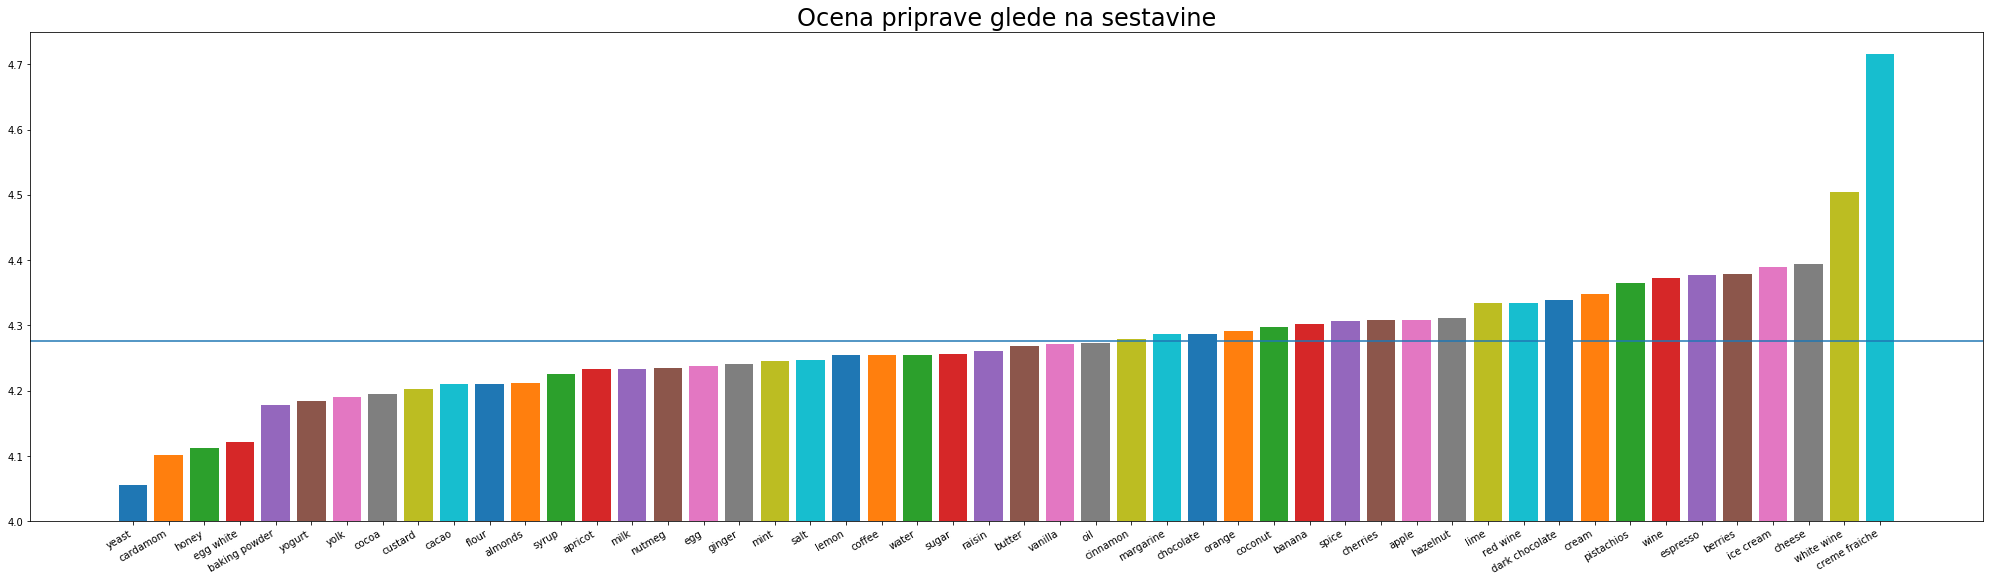

In [11]:
ratings = dict()
for ing in ingredient_list.ingredient:
    jo_contains_ing = jo_ingredients[jo_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    ar_contains_ing = ar_ingredients[ar_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    # print(f'{ing}: {len(jo_contains_ing.count())}')
    ar_recipes_with_ing = ar_recipes.filter(items=list(ar_contains_ing.count().index), axis=0)
    ar_rating = pd.DataFrame.from_dict(dict(ar_recipes_with_ing.rating.apply(to_rating).items()), columns=['value', 'count'], orient='index')
    ar_good_ratings = ar_rating[ar_rating['count'] > 0]
    ar_mean_rating = ar_good_ratings.value.mean()
    ar_total_count = ar_good_ratings['count'].sum()
    ratings[ing] = [ar_mean_rating, ar_total_count]

ar_rating_by_ingredient = pd.DataFrame.from_dict(ratings, orient='index', columns=['value', 'count'])
ar_rating_table = ar_rating_by_ingredient[ar_rating_by_ingredient['count'] >= 50].sort_values(by='value')  # odstranimo sestavine ki so malo zastopane
mean_rating = ar_rating_table.value.mean()

fig = plt.figure(figsize=(35,10))
ax1 = fig.add_subplot(111)
ax1.set_title("Ocena priprave glede na sestavine", size=24)
ax1.set_ylim(4, 4.75)
draw_with_mean(ax1, ar_rating_table, mean_rating, f=(lambda x: x.value))

Graf 5: Povprečna ocena za vsako sestavino.


Opazimo lahko, da je creme fraiche zelo priljubljena sestavina, kvasa pa ljudje načeloma ne marajo.

Čokolada zgleda ne vpliva precej na oceno sladice.

Temna čokolada ima malo višje povprečje.

Presenetljivo je med manj priljubljen.